In [12]:
%matplotlib inline

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import randint, uniform
from sklearn import linear_model, preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              RandomForestClassifier, RandomForestRegressor)
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_absolute_error, r2_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, OneHotEncoder,
                                   PolynomialFeatures, RobustScaler,
                                   StandardScaler)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

In [13]:
# import data
dataset_og = pd.read_csv('Data\Measurements-Transformed')
# kopie maken indien we iets van de originele data nodig hebben
dataset = dataset_og.copy()
dataset.head(5)

,ID,Sex,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
0,573539.0,0.0,57.0,0.0,-1.75,0.50,55.0,-2.25,1.0,55.0,-1.75,1.00,110.0,-1.25,0.5,110.0
1,573539.0,0.0,55.0,0.0,-1.75,0.50,65.0,0.00,0.0,0.0,-1.25,0.50,110.0,0.00,0.0,0.0
2,573539.0,0.0,49.0,0.0,-1.50,0.50,65.0,0.00,0.0,0.0,-1.00,0.50,110.0,0.00,0.0,0.0
3,186690.0,1.0,37.0,0.0,-3.50,1.50,180.0,-3.50,1.5,180.0,-3.00,1.50,180.0,-3.00,1.5,180.0
4,186690.0,1.0,26.0,0.0,-2.00,0.75,175.0,0.00,0.0,0.0,-2.00,0.75,180.0,0.00,0.0,0.0


### Eerst proberen per feat een model te maken

In [14]:
# Splitsen in features en targets
target = 'Sph-Far-R'

y = dataset[target].values
X = dataset.drop(target,axis=1)

In [15]:
# Splitsen in train en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42069)

In [21]:
# Linear regression
lregModel = linear_model.LinearRegression()
lregModel.fit(X_train,y_train)
print('r2 score = ', lregModel.score(X_test,y_test))

r2 score =  0.8381729865357483


In [25]:
# test hogere orde features
graad = 2

polyModel = PolynomialFeatures(graad)
polyModel.fit(X_train)
X_train_poly = polyModel.transform(X_train)
X_test_poly = polyModel.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)


# L2 regularisatie via Ridge regression
lregPolyModel = Ridge(alpha=0.5,tol=0.0001,fit_intercept=True)
lregPolyModel.fit(X_train_poly,y_train)

print('R2 score op training set via L2: ',lregPolyModel.score(X_train_poly,y_train))
print('R2 score op test set via L2: ',lregPolyModel.score(X_test_poly,y_test))
print('Intercept score op test set via L2: ',lregPolyModel.intercept_)


# L1 regularisatie via Lasso regression
lregPolyModel = Lasso(alpha=0.5,tol=0.00001,fit_intercept=True)
lregPolyModel.fit(X_train_poly,y_train) 

print('R2 score op training set via L1: ',lregPolyModel.score(X_train_poly,y_train))
print('R2 score op test set via L1: ',lregPolyModel.score(X_test_poly,y_test))
print('Intercept score op test set via L1: ',lregPolyModel.intercept_)

dimensie van X_train_poly:  (34271, 136)
R2 score op training set via L2:  0.9032400633232378
R2 score op test set via L2:  0.8493878857395591
Intercept score op test set via L2:  0.09220672689347448
R2 score op training set via L1:  0.8309687404617176
R2 score op test set via L1:  0.7834205674484387
Intercept score op test set via L1:  -0.6220645743624309


Text(0, 0.5, 'Performance')

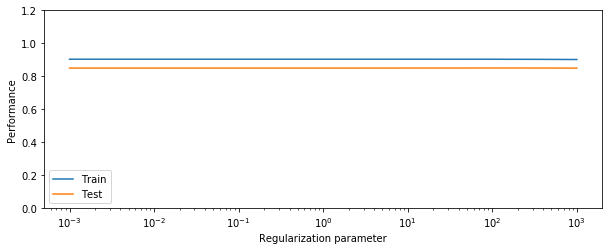

In [28]:
# Beetje rondprutsen me de alpha en de R2 scores in een graph smijten
alphas = np.logspace(-3, 3, 50)
train_r2 = []
test_r2 = []

for alpha in alphas:
    lregPolyModel = Ridge(alpha=alpha,tol=0.0001,fit_intercept=True)
    lregPolyModel.fit(X_train_poly,y_train)
    test_r2.append(lregPolyModel.score(X_test_poly,y_test))  
    train_r2.append(lregPolyModel.score(X_train_poly,y_train))

# Plot r2
f, ax = plt.subplots(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_r2, label='Train')
plt.semilogx(alphas, test_r2, label='Test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

In [29]:
# Aanmaken van de hogere orde features
RFR_model = RandomForestRegressor(n_estimators=100)
RFR_model.fit(X_train,y_train)

RFR_model.score(X_test,y_test)

0.9234020648396457

In [30]:
# Sliding window
window_size = 2
X_window = []
y_window = []

for w in range(window_size, X.shape[0]):
    X_window.append(X[w-window_size:w,:].reshape(1,-1))
    y_window.append(y[w-1])

X_window = np.asarray(X_window)
X_window = np.squeeze(X_window, axis=1)
y_window = np.asarray(y_window)

X_train, X_test, y_train, y_test = train_test_split(X_window, y_window, test_size=0.2, random_state=0 )

# Aanmaken van de hogere orde features
RFR_model.fit(X_train,y_train)
RFR_model.score(X_test,y_test)

TypeError: '(slice(0, 2, None), slice(None, None, None))' is an invalid key